#Content
- Assumption of Linear Regression
  - Assumption of Linearity
  - Features are not multi-Collinear
   - Collinearity
   - Multi-Collinearity

  - Errors are normally Distributed
  - Heteroskedasticity should not exist
  - No Autocorrelation


## Assumptions of Linear Regression

<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/755/original/z.png?1705226251' width=800>

- We can arrive at concept of Linear regression in two ways.
  - Algebra & Optimization (Geometric) - We covered this
  - Probability & Statistics
- We can prove that Linear regression is a very good model if all the statistical assumptions holds true.


## 1.Assumption of Linearity



<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/756/original/z.png?1705226286' width=800>

## 2. Non multi-collinear features


<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/757/original/z.png?1705226446' width=800>



<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/758/original/z.png?1705226504' width=800>

#### How can we remove these highly correlated features?

We will use something called VIF (Variance Inflation Factor)

Let's understand this with an example


<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/759/original/z.png?1705226538' width=800>



<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/760/original/z.png?1705226569' width=800>



<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/761/original/z.png?1705226618' width=800>



<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/762/original/z.png?1705226647' width=800>

Now lets see if there are any multi-collinear features in Cars24 data

we will be using Statsmodel for Linear Regression

For standardization of X we will be using Scikit Learn [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- Which does the implementation of Standardizing features for us

In [ ]:
# Statmodels implementation of Linear regression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df[df.columns.drop('selling_price')]
y = df["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

X_sm = sm.add_constant(X_tr_scaled)  #Statmodels default is without intercept, to add intercept we need to add constant

sm_model = sm.OLS(y_train, X_sm).fit()

print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.588e+04
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:34:26   Log-Likelihood:                -7.3180
No. Observations:               15856   AIC:                             48.64
Df Residuals:                   15839   BIC:                             179.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.223      0.8

#### Multicollinearity and implementation
- When one or more input variables exhibhit strong correlation
- One variable is enough to be part of the model.

In [ ]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
vif = pd.DataFrame()
X_t = pd.DataFrame(X_tr_scaled, columns=X_train.columns)
vif['Features'] = X_t.columns
vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
0,year,inf
5,age,inf
13,Petrol,18.30
10,Diesel,17.30
16,>5,13.04
15,5,11.75
3,engine,6.26
7,model,5.78
4,max_power,5.00
2,mileage,3.22


#### Note : VIF values tends to be infinity when there is a perfect correlation between the variables

Removing the variable with highest VIF

In [ ]:
cols2 = vif["Features"][1:].values
X2 = pd.DataFrame(X_tr_scaled, columns=X_train.columns)[cols2]

X2_sm = sm.add_constant(X2)  #Statmodels default is without intercept, to add intercept we need to add constant
sm_model = sm.OLS(list(y_train), X2_sm).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 1.588e+04
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:34:27   Log-Likelihood:                -7.3180
No. Observations:               15856   AIC:                             48.64
Df Residuals:                   15839   BIC:                             179.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0004      0.002  

As we see, there's no drop in R-sq. and adj. R-sq. value even after removing the variable

Let's now keep on removing features till we
- either have a feature with vif<5

or
- have the model's adj. r2 score go below 0.85

In [ ]:
vif_thr = 5
r2_thr = 0.85
i = 1
feats_removed = ['year']
while True:
  vif = pd.DataFrame()
  X_t = pd.DataFrame(X_tr_scaled, columns=X_train.columns)[cols2]
  vif['Features'] = cols2
  vif['VIF'] = [variance_inflation_factor(X_t.values, i) for i in range(X_t.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)

  cols2 = vif["Features"][1:].values
  X2 = pd.DataFrame(X_tr_scaled, columns=X_train.columns)[cols2]

  X2_sm = sm.add_constant(X2)  #Statmodels default is without intercept, to add intercept we need to add constant
  sm_model = sm.OLS(list(y_train), X2_sm).fit()
  if (vif.iloc[0]['VIF'] < vif_thr) or (sm_model.rsquared_adj < r2_thr):
    print('Reached threshold')
    print('Highest vif:',vif.iloc[0])
    print('Current adj.R2',sm_model.rsquared_adj)
    print('Features removed:', i)
    print('List of features removed:', feats_removed)
    break
  feats_removed.append(vif.iloc[0]['Features'])
  i += 1

Reached threshold
Highest vif: Features    model
VIF          5.75
Name: 0, dtype: object
Current adj.R2 0.8318553555450336
Features removed: 4
List of features removed: ['year', 'Petrol', '>5', 'engine']


In [ ]:
print(vif)
print(sm_model.summary())

            Features   VIF
0              model  5.75
1          max_power  3.31
2               make  3.16
3            mileage  2.28
5                age  1.88
6             Manual  1.77
4             Diesel  1.66
7                  5  1.47
9          km_driven  1.20
8           Electric  1.18
10        Individual  1.08
11  Trustmark Dealer  1.02
12               LPG  1.01
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     6538.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:34:29   Log-Likelihood:                -8348.2
No. Observations:               15856   AIC:                         1.672e+04
Df Residuals:                   15843   BIC:                         

## 3. Errors are normally distributed

<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/763/original/z.png?1705226711' width=800>



<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/764/original/z.png?1705226745' width=800>




<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/765/original/z.png?1705226826' width=800>

#### How do outliers impact linear regression?

Let's take a 2D e.g. of predicting the price from the given model.


<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/766/original/z.png?1705226858' width=800>

#### Question: After plotting the plot for errors, we see the curve is non-gaussian i.e. Outliers are present. How do we identify and remove these outlier?

Ans:

- Outliers will have large error value (yi - yi_hat).
- Remove the points will high error as many as you want and fit the model again.
- Check the distribtion of errors on new model and repeat.

Lets See how is the error distribution for Car24

In [ ]:
X_sm = sm.add_constant(X_tr_scaled)
sm_model = sm.OLS(y_train, X_sm).fit()

In [ ]:
Y_hat = sm_model.predict(X_sm)
errors = Y_hat - y_train

Text(0.5, 1.0, 'Histogram of residuals')

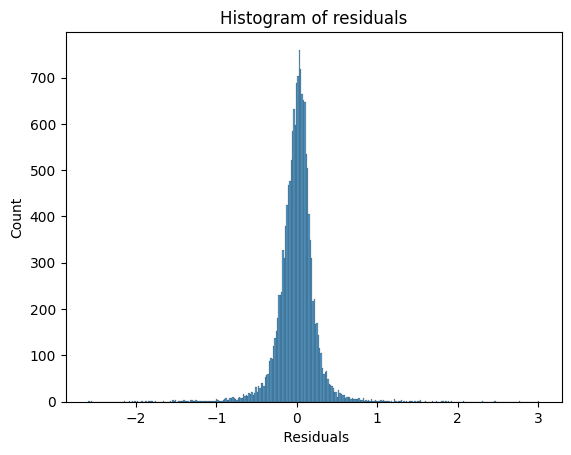

In [ ]:
import seaborn as sns
sns.histplot(errors)
plt.xlabel(" Residuals")
plt.title("Histogram of residuals")

This looks like a normal distribution, with a high mean and low S.D.

Let's do a normality test to check if the distribution is actually normal.

Recall:
- You must have studied Shapiro Wilk test in statistics module.

In [ ]:
from scipy import stats
res = stats.shapiro(errors)
res.statistic

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.8526061177253723

Closer the value to 1, more is the normality.

In this case, a value of 0.85 denotes a high level of normality for the error distribuiton

- If the distribution of errors is gaussian distribution then the assumption of error being normally distributed is being sastified (sanity check)



# 4.Heteroskedasticity should not exist

<!-- <img src='https://drive.google.com/uc?id=1_K0iQfncOvnbO4S3kQjQsX2Rsr2907cr' width=800> -->

<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/066/059/original/hetro.png?1708680988' width=800>

Lets implement heteroskedasticity in Cars24

In [ ]:
Y_hat = sm_model.predict(X_sm)
errors = Y_hat - y_train

Text(0.5, 1.0, 'Predicted values vs Residuals')

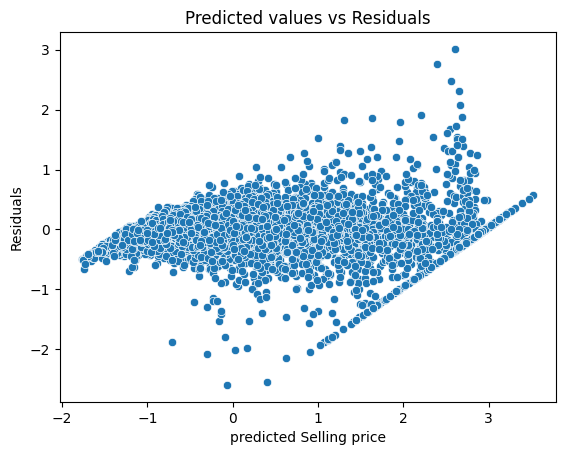

In [ ]:
sns.scatterplot(x=Y_hat,y=errors)
plt.xlabel("predicted Selling price")
plt.ylabel("Residuals")
plt.title("Predicted values vs Residuals")

- Notice that As we go from left to right,the spread of  errors is almost constant

#### What can we understand from this constant Residuals?
- We can assume that heteroskedasticity does not exist in our data
- There are outliers present in the dataset

We can also use "Goldfeld-Quandt Test" to verify our assumptions


### Using Goldfeld Quandt Test to check homoskedacity

- This test is used to test the presence of Heteroscedasticity in the given data
- The Goldfeld-Quandt test works by removing some number of observations located in the center of the dataset, then testing to see if the spread of residuals is different from the resulting two datasets that are on either side of the central observations.

In [ ]:
# Performing the Goldfeld-Quandt test to check for Homoscedasticity -
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(y_train, X2_sm)
lzip(name, test)

[('F statistic', 1.0084600947540285), ('p-value', 0.35392832073679753)]

From the goldfeld-quandt test:
- F Statistic comes out to be 1.00 => Implying minimal difference in variance between groups
- p-value of 0.353 indicates that this difference is  statistically significant at conventional levels of significance (e.g., 0.05).

Therefore, we accept the null hypothesis of homoscedasticity, and conclude that there is no strong evidence of heteroscedasticity in the data.


**Note**:
In case we encounter heteroskedacity, we can use the following methods to remove the same:
- We can use transformations such as log, sq.rt., or boxcox transformation to remove heteroskedacity.
- Also, removing outliers will help.


# 5. No Autocorrelation

<img src='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/061/769/original/z.png?1705226962' width=800>

#### Summing up

- Summing up the Assumptions:
  - There exist a linear function
  - There is no auto correlation (related to time series)
  - Errors are normally distributed
  - No heteroskedasticity
  - No multicollinearity

We also have a fundamental assumption: $x^{(i)}, y^{(i)}$ are a random sample